In [115]:
from IPython import display
import os
import torch

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании будем работать с [notMNIST](http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz). Датасет представляет из себя 10 классов - стандартные и не очень начертания букв от A до J. 

In [116]:
import pickle

with open('notMNIST_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
    
with open('notMNIST_test.pickle', 'rb') as f:
    X_test = pickle.load(f)
    
with open('notMNIST_train_labels.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('notMNIST_test_labels.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [117]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

Посмотрим на данные. (Они уже отнормированы)

In [118]:
print('Max: {}, min: {}'.format(X_train.max(), X_train.min()))

Max: 0.5, min: -0.5


C


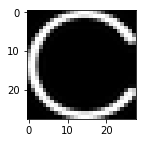

F


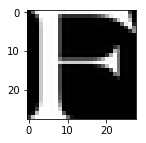

H


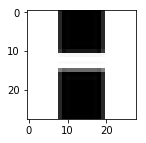

G


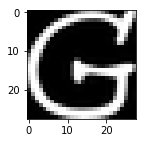

F


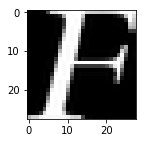

C


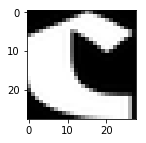

F


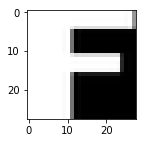

B


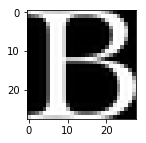

E


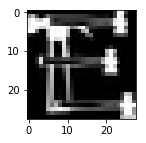

H


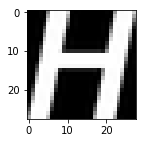

In [119]:
for i in range(10):
    sample_id = np.random.randint(0, len(y_train))
    print(y_train[sample_id])
    plt.figure(figsize=(2,2))
    plt.imshow(X_train[sample_id], cmap='gray')
    plt.show()

Выполним OneHotEncoding, и превратим данные в Pytorch.tensor

In [120]:
oneHotEncoder = OneHotEncoder()
y_train_one_hot = oneHotEncoder.fit_transform(y_train_encoded.reshape(-1, 1)).toarray()
y_test_one_hot = oneHotEncoder.fit_transform(y_test_encoded.reshape(-1, 1)).toarray()

In [121]:
def to_tensor(X):
    return torch.from_numpy(X.astype('float32'))

In [122]:
X_train = to_tensor(X_train)
X_test = to_tensor(X_test)
y_train = to_tensor(y_train_one_hot)
y_test = to_tensor(y_test_one_hot)

Вернёмся к коду с семинара, воспользуемся им, чтобы обучить сеть

In [123]:
from __future__ import print_function
from torch.autograd import Variable

Абстрактный слой. Два метода: forward - код, выполняющий прямой проход (реализуется для каждого слоя отдельно), backward - обратный проход, принимает optimizer, который делает всю грязную работу по обучению. Дополнительное поле - runtime для сохранения временных значений, необходимых в процессе обучения (например для момента градиента). Дополнительный метод visualize - вспомогательный, для вывода информации о слое.

In [124]:
class Layer(object):
    '''
        Абстрактный класс слоя
        
        input_shape - размер входного тензора, например (-1, 28, 28). 
        -1 означает, что размер по этой оси будет определяться в момент исполнения. 
        В данном случае -1 соответствует оси кол-ву элементов в батче (т.к. проход применяется ко всему батчу)
        
        output_shape - размер выходного тензора
    '''
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.params = []
        self.runtime = []
        self.trainable = True
    '''
        Прямой проход
        
        input - входные данные размера self.input_shape
        
        test - флаг, указывающий на то, что сеть работает в режиме тестирования, а не обучения
    '''
    def forward(self, input, test=False):
        assert False, 'Abstract class'
    '''
        Обратный проход
        optimizer - объект с функцией update(params, output), обновляющий параметры
    '''
    def backward(self, optimizer):
        optimizer.update(self.params, self.runtime)
        
    def visualize(self):
        assert False, 'Abstract class'

Полносвязный слой. Два переменных-параметра - weights и bias. (Делает преобразование вида $x W + b$, если вдруг кто-то смог забыть.)

In [125]:
class Dense(Layer):
    '''
        Полносвязный слой.
        
        input_size - кол-во фичей на входе
        output_size - кол-во фичей на выходе
    '''
    def __init__(self, input_size, output_size):
        assert input_size > 0
        assert output_size > 0
        super(Dense, self).__init__((-1, input_size), (-1, output_size))
        self.weights = Variable(torch.randn((input_size, output_size))/np.sqrt(input_size), requires_grad=True)
        self.bias = Variable(torch.randn(output_size)/np.sqrt(input_size), requires_grad=True)
        self.params = [self.weights, self.bias]
    
    def forward(self, x, test=False):
        self.output = x @ self.weights + self.bias
        return self.output
    
    def visualize(self):
        print('Dense Layer {}->{}'.format(self.input_shape, self.output_shape))

Слой, делающий нелинейное преобразование ReLU.

In [126]:
class ReLU(Layer):
    '''
        ReLU
    '''
    def __init__(self, input_shape):
        super(ReLU, self).__init__(input_shape, input_shape)
        self.trainable = False
    
    def forward(self, x, test=False):
        self.output = x.clamp(min = 0)
        return self.output
    
    def visualize(self):
        print('Relu {}'.format(self.input_shape))

Слой, возвращающий *логарифм* преобразования Softmax ($softmax(x)_{i} = \frac{e^{x_i}}{\sum_{j}e^{x_j}}$) Мы берём логарифм, т.к. это вычисление более стабильно и имеет готовую реализацию.

In [127]:
class Softmax(Layer):
    '''
        Softmax 
    '''
    def __init__(self, input_size):
        super(Softmax, self).__init__((-1, input_size), (-1, input_size))
        self.trainable = False
    
    def forward(self, x, test=False):
        self.output = torch.nn.functional.log_softmax(x)
        return self.output
    
    def visualize(self):
        print('Softmax {}'.format(self.input_shape))

 Слой, меняющий форму переданного тензора. Напоминание: .view() - преобразование формы тензора.

In [128]:
class Transform(Layer):
    '''
     Изменение формы
    '''
    def __init__(self, input_shape, output_shape):
        super(Transform, self).__init__(input_shape, output_shape)
        self.trainable = False
        
    def forward(self, x, test=False):
        return x.view(self.output_shape)
    
    def visualize(self):
        print('Transform {}->{}'.format(self.input_shape, self.output_shape))

Абстрактная функция потерь. do_forward() - подсчёт функции потерь

In [129]:
class Loss(object):
    '''
        Абстрактная фуенкция потерь
    '''
    def forward(self, x, y, params, test=False):
        self.output = self.do_forward(x, y, params, test)
        return self.output
    
    def backward(self):
        self.output.backward()
        
    def do_forward(self, x, y, params, test=False):
        assert False, 'Abstract class'
        
    def visualize(self):
        assert False, 'Abstract class'
    

Кросс-энтропия $\sum_{l \in samples} \sum_{i \in classes} -y_{i}^{(l)}log(\hat{y_{i}}^{(l)})$. Т.к. softmax уже берёт логарифм, тут мы его не берём.

In [130]:
class CrossEntropy(Loss):
    '''
        Кросс-энтропия
    '''
    def do_forward(self, x, y, params, test=False):
        return torch.sum(-1*y* torch.squeeze(x))
    
    def visualize(self):
        print('Cross entropy')

SeqNet - класс последовательной сети. 
- add() - добавить в конец новый слой
- setLoss() - установить функцию потерь
- forward() - последовательный прямой проход по добавленным слоям
- backward() - обратный проход и обновление параметров
- visualize() - вывод слоёв

In [131]:
class SeqNet:
    '''
        Сеть, связывающая слои последовательно
    '''
    def __init__(self, *args):
        self.layers = []
        self.output = None
        self.loss = None
        self.params = []
        self.fine_tune = False
        
    def add(self, layer):
        if len(self.layers) > 0:
            assert self.layers[-1].output_shape == layer.input_shape, \
                'Неправильны размер входа. Ожидался {}, но был получен {}'.format(self.layers[-1].output_shape, layer.input_shape)
        self.layers.append(layer)
        self.params.append(layer.params)
        
    def add_multiple(self, *args):
        for arg in args:
            net.add(arg)
        
    def setLoss(self, loss):
        self.loss = loss
        
    def forward(self, x, y=None, test=False):
        self.output = x
        for layer in self.layers:
            self.output = layer.forward(self.output, test)
        if (self.loss is not None) and (y is not None):
            self.loss_value = self.loss.forward(self.output, y, self.params, test)
        return self.output
    
    def backward(self, optimizer):
        self.loss.backward()
        for layer in self.layers[::-1]:
            if layer.trainable:
                layer.backward(optimizer)
            
    def visualize(self):
        for layer in self.layers:
            layer.visualize()
        if self.loss:
            self.loss.visualize()

Optimizer - ответственный за обновление весов. Получает на вход update() список параметров и список runtime-переменных.

In [132]:
class Optimizer:
    '''
         Абстрактный класс "оптимизатора"
    '''
    
    '''
         Вызывается после каждой эпохи
    '''
    def update_epoch(self, n):
        assert False, 'Abstract class'
    
    '''
        Обновление параметров
    '''
    def update(self, params, runtime):
        assert False, 'Abstract class'

In [133]:
class SimpleOptimizer(Optimizer):
    '''
        Простой "оптимизатор" с фиксированным learning rate
    '''
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def update_epoch(self, n):
        pass
        
    def update(self, params, runtime):
        for param in params:
            param.data -= self.learning_rate * param.grad.data

Функции для итерации батчей, обучения и подсчёта Accuracy

In [134]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
def accuracy(result, val_tensor):
    t, ind_result = torch.max(result, 1)
    t, ind_val = torch.max(val_tensor, 1)
    return (torch.sum((ind_result==ind_val).float())/len(val_tensor)).data.numpy()[0]

def train(net, optimizer, n_epochs, batch_size, X, y, X_test, y_test, shuffle=False):
    loss_history = []
    test_history = []
    x_tensor = Variable(torch.FloatTensor((batch_size, X.shape[1], X.shape[2])))
    test_tensor = Variable(X_test)
    val_tensor = Variable(y_test)
    y_tensor = Variable(torch.FloatTensor((batch_size, y.shape[1])))
    for i in range(n_epochs):
        loss_per_batch = []
        for x_batch, y_batch in iterate_minibatches(X, y, batch_size, shuffle):
            x_tensor.data=x_batch
            y_tensor.data=y_batch
            net.forward(x_tensor, y_tensor)
            loss_per_batch.append(net.loss_value.data.numpy()[0])
            net.backward(optimizer)
        optimizer.update_epoch(i)
        display.clear_output()
        result = net.forward(test_tensor, val_tensor, True)
        test_history.append(net.loss_value.data.numpy()[0]/len(X_test))
        print('Accuracy:{}'.format(accuracy(result, val_tensor)))
        loss_history.append(np.sum(loss_per_batch)/len(X))
        assert loss_history[-1] >=0
        plt.plot(np.arange(i+1), loss_history, label='train')
        plt.plot(np.arange(i+1), test_history, label='test')
        plt.legend()
        plt.show()

Построим сеть:

In [135]:
net = SeqNet()
net.add(Transform((-1, 28, 28), (-1, 28*28)))
net.add(Dense(28*28, 320))
net.add(ReLU((-1, 320)))
net.add(Dense(320, 10))
net.add(Softmax(10))
net.setLoss(CrossEntropy())

net.visualize()

Transform (-1, 28, 28)->(-1, 784)
Dense Layer (-1, 784)->(-1, 320)
Relu (-1, 320)
Dense Layer (-1, 320)->(-1, 10)
Softmax (-1, 10)
Cross entropy


Accuracy:0.8797265291213989


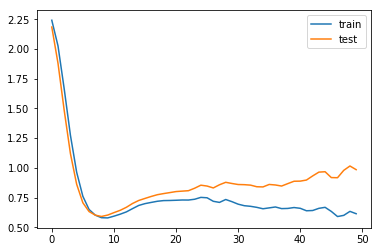

In [22]:
optimizer = SimpleOptimizer(1e-7)
train(net, optimizer, 50, 128, X_train, y_train, X_test, y_test)

Кажется, модель переобучается. Попробуем это исправить

### Задание 1: Градиентный спуск (1 балл)

Изменим градиентный спуск - добавим момент

$v_t = \beta v_{t-1} + \text{learning_rate} * \nabla_w J $  
$w_t = w_{t-1} - v_t$

In [136]:
from torch import FloatTensor, IntTensor

class Moment:
    '''
        Класс, хранящийся в списке runtime в слое. 
        Если список пуст, а параметры у слоя есть, то инициализируются в init_runtime()
    '''
    def __init__(self, shape):
        self.moment = FloatTensor(torch.from_numpy(np.zeros(shape, dtype='float32')))

class MomentOptimizer(Optimizer):
    def __init__(self, learning_rate, beta):
        self.learning_rate = learning_rate
        self.beta = beta
    
    def update_epoch(self, n):
        pass
    
    def update(self, params, runtime):
        if len(runtime) == 0 and len(params) > 0:
            self.init_runtime(params, runtime)
        for i in range(len(runtime)):
            runtime[i].moment = self.beta * runtime[i].moment + self.learning_rate * params[i].grad.data
            params[i].data -= runtime[i].moment
            
    def init_runtime(self, params, runtime):
        for param in params:
            runtime.append(Moment(tuple(param.data.shape)))

In [137]:
net = SeqNet()
net.add(Transform((-1, 28, 28), (-1, 28*28)))
net.add(Dense(28*28, 320))
net.add(ReLU((-1, 320)))
net.add(Dense(320, 10))
net.add(Softmax(10))
net.setLoss(CrossEntropy())

net.visualize()

Transform (-1, 28, 28)->(-1, 784)
Dense Layer (-1, 784)->(-1, 320)
Relu (-1, 320)
Dense Layer (-1, 320)->(-1, 10)
Softmax (-1, 10)
Cross entropy


Accuracy:0.8523819446563721


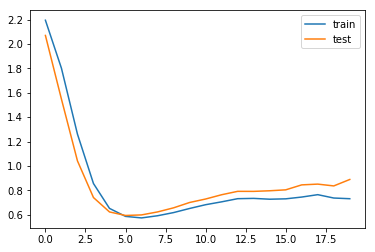

In [35]:
optimizer = MomentOptimizer(1e-7, 0.5)
train(net, optimizer, 20, 128, X_train, y_train, X_test, y_test)

Всё ещё сильное переобучение.

### Задание 2: Регуляризация  (1 балл)

Добавим L2-регуляризацию - сумму квадратов параметров по всем слоям. Также надо не забыть, что вычисления ведутся по батчу, а значит надо штрафовать пропорционально размеру батча

In [138]:
class CrossEntropyL2(Loss):
    '''
        Кросс-энтропия c L2 регуляризацией
    '''
    def __init__(self, l2_coeff):
        self.l2_coeff = l2_coeff
    
    def do_forward(self, x, y, params, test=False):
        params_sum = 0
        for layer_params in params:
            for param in layer_params:
                params_sum += torch.sum(param.data ** 2)
        return torch.sum(-1*y* torch.squeeze(x)) + params_sum * self.l2_coeff * x.size()[0]
    
    def visualize(self):
        print('Cross entropy with L2')

In [139]:
net = SeqNet()
net.add(Transform((-1, 28, 28), (-1, 28*28)))
net.add(Dense(28*28, 320))
net.add(ReLU((-1, 320)))
net.add(Dropout(320))
net.add(Dense(320, 10))
net.add(Softmax(10))
net.setLoss(CrossEntropyL2(0.1))

net.visualize()

Transform (-1, 28, 28)->(-1, 784)
Dense Layer (-1, 784)->(-1, 320)
Relu (-1, 320)
Dropout (-1, 320) /*/ 0.3
Dense Layer (-1, 320)->(-1, 10)
Softmax (-1, 10)
Cross entropy with L2


Accuracy:0.9013031125068665


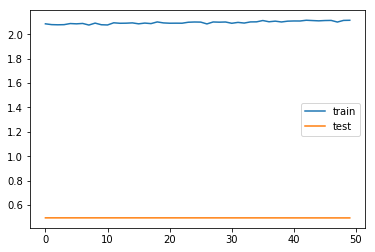

In [125]:
optimizer = Adam(1e-6)
train(net, optimizer, 50, 128, X_train, y_train, X_test, y_test)

In [73]:
def debug(*args):
    for arg, name in args:
        
        print(name)
        print(arg)
        print(f"is nan: {np.isnan(np.sum(arg.numpy()))}")
        print(f"is inf: {np.isinf(np.sum(arg.numpy()))}")
        print(f"has zeros: {arg.numpy().size-np.count_nonzero(arg.numpy())}")
        print('\n')

### Задание 3: Свёрточные сети (2 балла)

Создадим свёрточный слой и max pooling слой. Мы могли бы их честно реализовать с помощью операций на тензорах, но их производительность была бы крайне низкой. Так что воспользуемся готовыми функциями torch.nn.functional.conv2d и torch.nn.functional.max_pool2d

In [140]:
class Conv(Layer):
    def __init__(self, input_width, input_height, input_depth, kernel_size, n_filters, stride=1, padding=0):
        super(Conv, self).__init__((-1, input_depth, input_width, input_height),
                                   (-1, n_filters, (input_width+2*padding-kernel_size+1)//stride,
                                                   (input_height+2*padding-kernel_size+1)//stride))
        self.n_filters = n_filters
        self.input_width = input_width
        self.input_height = input_height
        self.input_depth = input_depth
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.filters = torch.autograd.Variable(
            torch.randn((
                self.n_filters,
                self.input_depth,
                self.kernel_size,
                self.kernel_size
            )) / np.sqrt(n_filters * kernel_size * kernel_size),
            requires_grad=True
        )
        self.bias = torch.autograd.Variable(
            torch.from_numpy(np.zeros(n_filters, dtype='float32')),
            requires_grad=True
        )
        self.params = [self.filters, self.bias]
    
    def forward(self, x, test=False):
        self.output = torch.nn.functional.conv2d(
            x,
            self.filters,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding
        )
        return self.output
    
    def visualize(self):
        return 'Conv {}×{} \t\t({}, {}, {}) → ({}, {}, {})'.format(
            self.kernel_size, self.kernel_size,
            self.input_depth, self.input_width, self.input_height,
            self.n_filters, self.output_shape[2], self.output_shape[3]
        )
        
class MaxPool(Layer):
    def __init__(self, input_width, input_height, input_depth, kernel_size):
        super(MaxPool, self).__init__((-1, input_depth, input_width, input_height),
                                   (-1, input_depth, input_width//kernel_size,
                                                   input_height//kernel_size))
        self.input_depth = input_depth
        self.input_width = input_width
        self.input_height = input_height
        self.kernel_size = kernel_size
        self.trainable = False
    
    def forward(self, x, test=False):
        self.output = torch.nn.functional.max_pool2d(
            x,
            self.kernel_size
        )
        return self.output
    
    def visualize(self):
        return 'Max Pool2d {} \t{} → {}'.format(self.kernel_size, self.input_shape, self.output_shape)

Следующая сеть просто проверяет корректность реализации и не даёт хорошего результата

In [141]:
net = SeqNet()
net.add_multiple(
    Transform((-1, 28, 28), (-1, 1, 28, 28)),
    Conv(28, 28, 1, 5, 10),
    ReLU((-1, 10, 24, 24)),
    MaxPool(24, 24, 10, 2),
    Conv(12, 12, 10, 5, 20),
    ReLU((-1, 20, 8, 8)),
    MaxPool(8, 8, 20, 2),
    Transform((-1, 20, 4, 4), (-1, 20*4*4)),
    Dense(20*4*4, 10),
    Softmax(10),
)
net.setLoss(CrossEntropyL2(0.0002))
net.visualize()

Transform (-1, 28, 28)->(-1, 1, 28, 28)
Relu (-1, 10, 24, 24)
Relu (-1, 20, 8, 8)
Transform (-1, 20, 4, 4)->(-1, 320)
Dense Layer (-1, 320)->(-1, 10)
Softmax (-1, 10)
Cross entropy with L2


Accuracy:0.765007495880127


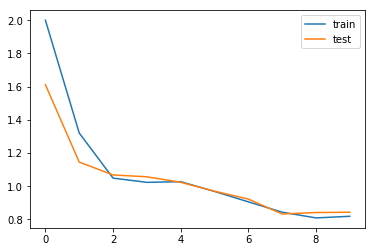

In [142]:
optimizer = Adam(1e-4)
train(net, optimizer, 10, 128, X_train, y_train, X_test, y_test)

### Задание 4: Собственная сеть (6 баллов)

А теперь настало время написать собственную сеть. За вдохновением можно обратиться к архитектурам подобным [LeNet 5](https://www.pyimagesearch.com/wp-content/uploads/2016/06/lenet_architecture.png).
Для этого надо воспользоваться всем инструментарием, который мы уже написали и реализовать хотя бы один дополнительный оптимизатор или слой.
#### Критерии:
1. Реализовано хотя бы одно из слеующего (2 балла):
    - Dropout
    - Adam (модификация градиентного спуска)
    - RMSProp (модификация градиентного спуска)
2. Получен Accuracy >=0.91 на тестовом сете (2 балла)
3. Получен Accuracy >=0.92.5 на тестовом сете (1 балл)
4. Получен Accuracy >=0.94 на тестовом сете (1 балл)

Обучение должно занимать меньше 10 минут на CPU (этого времени более, чем достаточно для получения требуемых результатов). При обучении данные тестового датасета не должны использоваться кроме как для замера качества.

Советы по реализации:
  - Не переусложняйте. Не надо пытаться сделать очень глубокую сеть - они слишком сложны для такой задачи и будут только переобучаться.
  - 50 (даже 30) эпох более, чем достаточно для достижения цели
  - Dropout наиболее эффективно работает перед полносвязными слоями
  - Если сеть совсем не обучается или значения функции потерь сильно скачут - скорее всего неверно подобран learning rate

#### На выбор:
##### Dropout
Dropout можно реализовать поэлементным перемножением входного тензора на тензор со сгенерированными нулями и единицами, полученными, например, с помощью *np.random.binomial(1, self.p, tuple(x.data.shape))*.  
Не забудьте, что dropout вне режима обучения просто домножает значения на ту вероятность, с которой пропускался сигнал в режиме обучения. Отличать режимы можно с помощью параметра *test* в *forward()*

##### RMSprop
RMSprop на t-й итерации вычисляется следующим образом:  
$v_t=\gamma v_{t−1}+(1−\gamma)g_t^2$  
$w_t = w_{t-1} - \frac{\eta}{\sqrt{v_t+\epsilon}} g_t $

$\gamma$ - гиперпараметр, обычно ~0.9
$g_t$ - градиент параметров на t-й итерации  
$w_t$ - параметры на t-й итерации  
$\eta$ - learning rate  
$\epsilon$ ~ $10^{-8}$ - для избежания деления на 0

##### Adam
Adam на t-й итерации вычисляется следующим образом:  
$m_t = \beta_1 m_{t−1}+(1−\beta_1)g_t$  
$v_t=\beta_2 v_{t−1}+(1−\beta_2)g_t^2$  
$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$  
$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$  
$w_t = w_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t}+\epsilon} \hat{m}_t $

$\beta_1$, $\beta_2$ - гиперпараметры, обычно ~0.9 и ~0.999   
$g_t$ - градиент параметров на t-й итерации  
$w_t$ - параметры на t-й итерации  
$\eta$ - learning rate  
$\epsilon$ ~ $10^{-8}$ - для избежания деления на 0



In [83]:
class AdamMoment:
    '''
        Класс, хранящийся в списке runtime в слое. 
        Если список пуст, а параметры у слоя есть, то инициализируются в init_runtime()
    '''
    def __init__(self, shape):
        self.momentV = FloatTensor(torch.from_numpy(np.zeros(shape, dtype='float32')))
        self.momentM = FloatTensor(torch.from_numpy(np.zeros(shape, dtype='float32')))
        
class Adam(Optimizer):
    
    def update(self, params, runtime):
        beta1 = self.beta1
        beta2 = self.beta2
        #print(runtime)
        if len(runtime) == 0 and len(params) > 0:
            self.init_runtime(params, runtime)
        for i in range(len(runtime)):
            try:
                runtime[i].momentM = runtime[i].momentM * beta1 + (1 - beta1) * params[i].grad.data
                runtime[i].momentV = runtime[i].momentV * beta2 + (1 - beta2) * params[i].grad.data ** 2

                m = runtime[i].momentM / (1 - beta1)
                v = runtime[i].momentV / (1 - beta2)

                params[i].data -= m * self.learning_rate / ((v + self.epsilon) ** 0.5)
            except AttributeError:
                print('Weird shit happened: no Params gradient')
                print(params[i])
                print(params[i].grad)
                raise AssertionError
            
    def __init__(self, learning_rate, beta1=0.9, beta2=0.999):
        
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 10e-8
        
    def update_epoch(self, n):
        pass
    def init_runtime(self, params, runtime):
        for param in params:
            runtime.append(AdamMoment(tuple(param.data.size())))

In [145]:
class Dropout(Layer):
    '''
     Having fun disabling some neurons
    '''
    def __init__(self, input_shape, dropout_rate=0.3):
        super(Dropout, self).__init__((-1, input_shape), (-1, input_shape))
        self.dropout_rate = dropout_rate
        self.trainable = False
        
    def forward(self, x, test=False):
        #print('a')
        if not test:
            dropped_matrix = np.random.binomial(1, p=self.dropout_rate, size=self.input_shape[1])
            dropped_matrix = np.tile(dropped_matrix.astype(np.float32), (x.size()[0], 1))
            dropped_matrix = Variable(torch.from_numpy(dropped_matrix), requires_grad=False)
            return dropped_matrix * x
        if test:
            return x * self.dropout_rate
    
    def visualize(self):
        print('Dropout {} /*/ {}'.format(self.input_shape, self.dropout_rate))
        
class RMSprop(Optimizer):
    '''
        I am just like adam
    '''
    def __init__(self, learning_rate, gamma=0.9, epsilon=10e-8):
        
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
    
    def update_epoch(self, n):
        pass
    
    def update(self, params, runtime):
        if len(runtime) == 0 and len(params) > 0:
            self.init_runtime(params, runtime)
        for i in range(len(runtime)):
            runtime[i].moment = self.gamma * runtime[i].moment + (1 - self.gamma) * (params[i].grad.data ** 2)
            params[i].data -= self.learning_rate / ((runtime[i].moment + self.epsilon) ** 0.5) * params[i].grad.data
            
    def init_runtime(self, params, runtime):
        for param in params:
            runtime.append(Moment(tuple(param.data.shape)))

In [146]:
'''
Convolutional layer with 30 feature maps of size 5×5.
Pooling layer taking the max over 2*2 patches.
Convolutional layer with 15 feature maps of size 3×3.
Pooling layer taking the max over 2*2 patches.
Dropout layer with a probability of 20%.
Flatten layer.
Fully connected layer with 128 neurons and rectifier activation.
Fully connected layer with 50 neurons and rectifier activation.
Output layer.


Conv(self, input_width, input_height, input_depth, kernel_size, n_filters, stride=1, padding=0)
MaxPool(self, input_width, input_height, input_depth, kernel_size)
'''
net = SeqNet()
net.add_multiple(
    Transform((-1, 28, 28), (-1, 1, 28, 28)),
    
    Conv(28, 28, 1, 5, 10),
    ReLU((-1, 10, 24, 24)),
    MaxPool(24, 24, 10, 2),
    
    Conv(12, 12, 10, 5, 30),
    ReLU((-1, 30, 8, 8)),
    MaxPool(8, 8, 30, 2),
    
    Transform((-1, 30, 4, 4), (-1, 30*4*4)),
    Dropout(30* 4 * 4, 0.5),
    Dense(30 * 4 * 4, 100),
    ReLU((-1, 100)),
    Dropout(100, 0.5),
    Dense(100, 10),
    Softmax(10),
)
net.setLoss(CrossEntropyL2(1e-5))
net.visualize()

Transform (-1, 28, 28)->(-1, 1, 28, 28)
Relu (-1, 10, 24, 24)
Relu (-1, 30, 8, 8)
Transform (-1, 30, 4, 4)->(-1, 480)
Dropout (-1, 480) /*/ 0.5
Dense Layer (-1, 480)->(-1, 100)
Relu (-1, 100)
Dropout (-1, 100) /*/ 0.5
Dense Layer (-1, 100)->(-1, 10)
Softmax (-1, 10)
Cross entropy with L2


Accuracy:0.9092074632644653


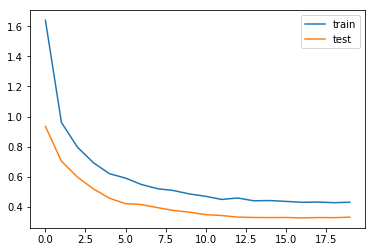

In [147]:
optimizer = Adam(1e-4)
train(net, optimizer, 20, 32, X_train, y_train, X_test, y_test)

Accuracy:0.9190344214439392


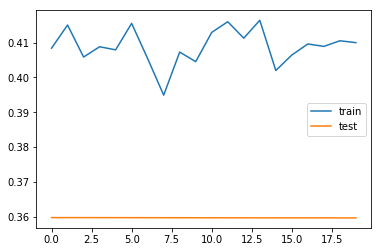

In [151]:
# Adjusting by finetuning
net.layers[1].trainable = False
net.layers[4].trainable = False

# Все же больше 92% не выжал
optimizer = Adam(1e-5)
train(net, optimizer, 20, 128, X_train, y_train, X_test, y_test)

### Бонус - визуализация свёрточной сети

Картинки, дающие максимальный отклик фильтров. Получим их с помощью магии autograd, взяв градиент по входной картинке.

In [48]:
def maximize(filter_id, net, layer_id):
    input = Variable(torch.randn((1, 28,28)), requires_grad = True)
    optimizer = MomentOptimizer(3, 0.5)
    runtime = []
    params = [input]
    for i in range(5000):
        net.forward(input)
        f = -torch.sum(net.layers[layer_id].output[:, filter_id, :, :])
        f.backward()
        optimizer.update(params, runtime)
    plt.imshow(input.data.numpy()[0], cmap='gray')
    plt.show()
    
first_level = 1
first_level_filters =  net.layers[first_level].filters
second_level = 4
second_level_filters = net.layers[second_level].filters

Первый свёрточный слой (после нелинейности). Как видно фильтры этого слоя выделяют штрихи в разных направлениях

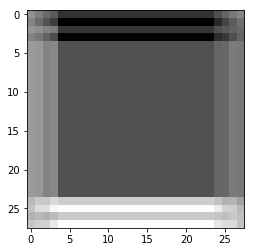

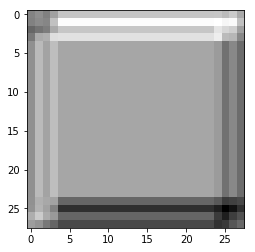

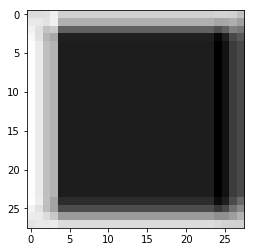

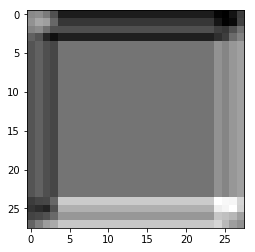

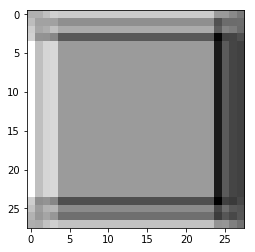

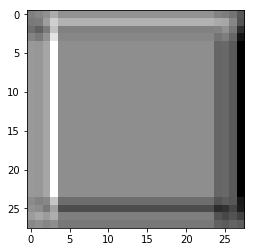

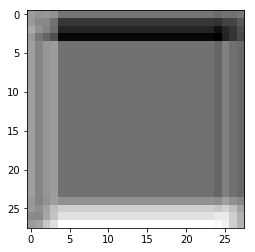

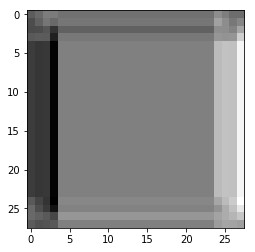

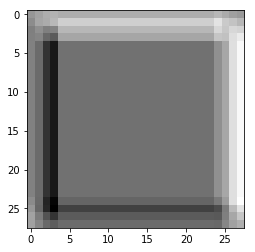

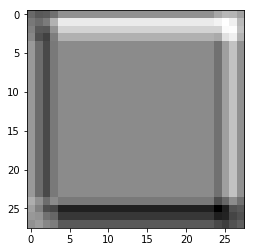

In [72]:
for i in range(len(first_level_filters.data)):
    maximize(i, net, first_level)

Второй свёрточный слой (после нелинейности). Фильтры выделяют более сложные паттерны.

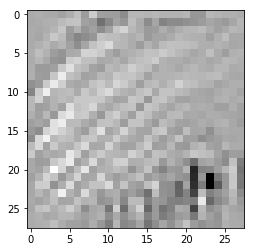

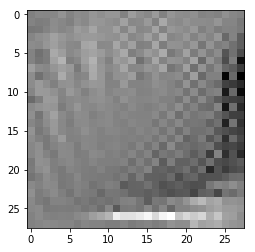

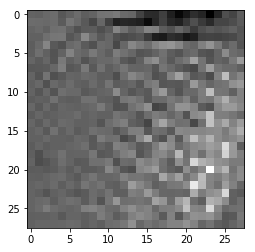

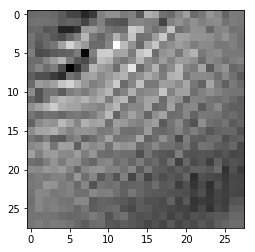

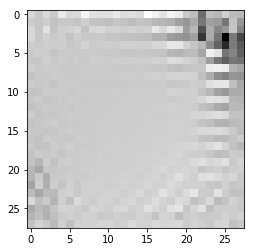

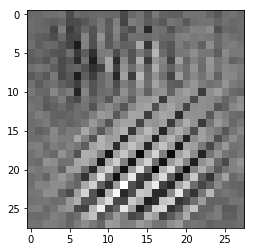

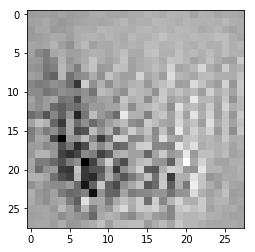

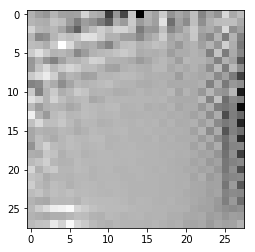

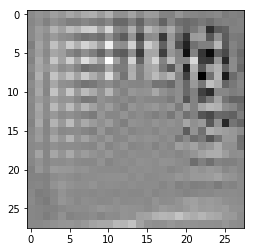

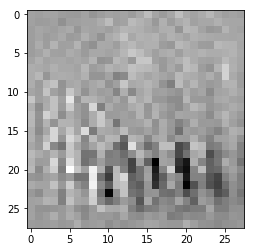

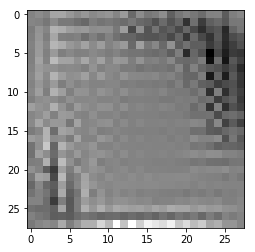

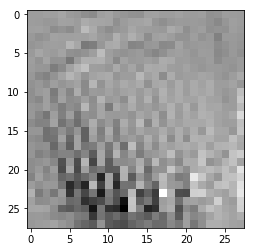

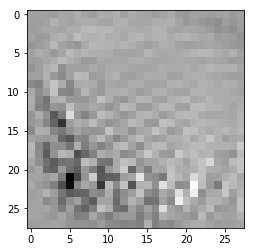

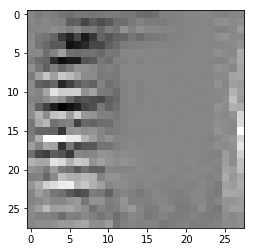

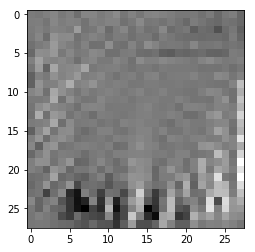

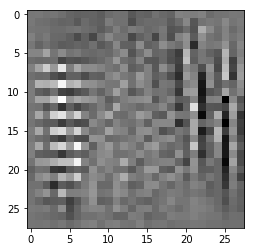

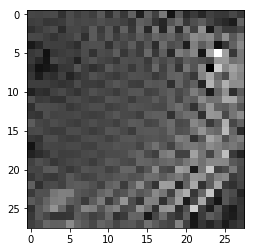

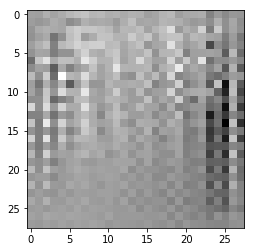

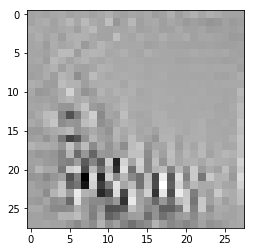

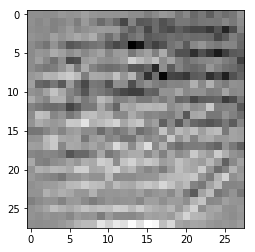

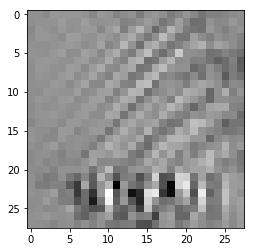

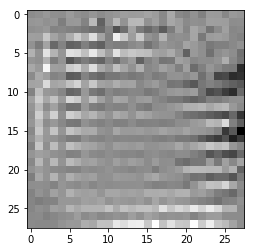

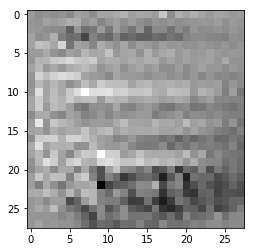

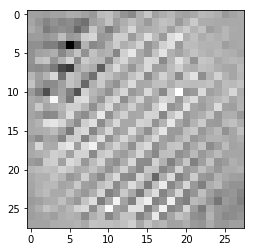

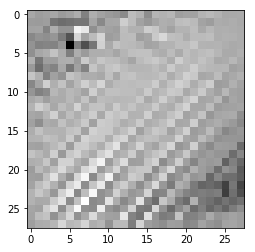

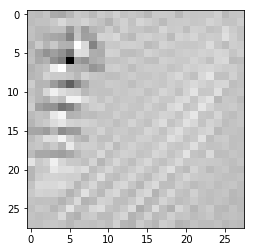

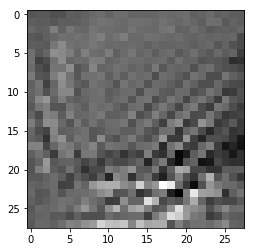

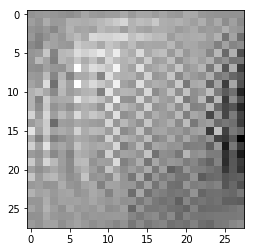

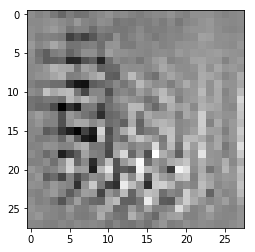

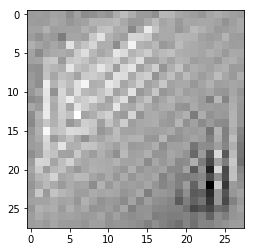

In [73]:
for i in range(len(second_level_filters.data)):
    maximize(i, net, second_level)

Посмотрим, как выглядят карты признаков для случайной буквы из датасета.

In [74]:
'''
    Карты признаков
'''
def visualize_feature_maps(net, sample):
    net.forward(Variable(sample), test=True)
    fig, axes = plt.subplots(2, len(first_level_filters.data), figsize=(20, 5))
    for i in range(len(first_level_filters.data)):
        axes[0, i].imshow(net.layers[1].output.data.numpy()[0, i, :, :], cmap='gray')
        axes[1, i].imshow(net.layers[3].output.data.numpy()[0, i, :, :], cmap='gray')
    fig, axes = plt.subplots(2, len(second_level_filters.data), figsize=(20, 5))
    for i in range(len(second_level_filters.data)):
        axes[0, i].imshow(net.layers[4].output.data.numpy()[0, i, :, :], cmap='gray')
        axes[1, i].imshow(net.layers[6].output.data.numpy()[0, i, :, :], cmap='gray')
    plt.show()


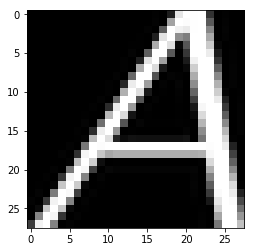

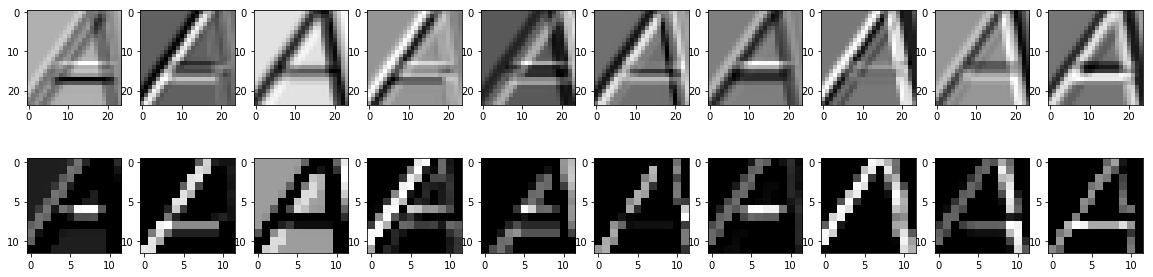

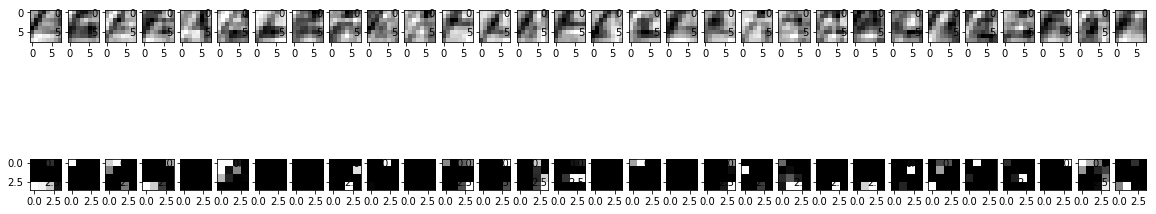

In [75]:
sample_id = np.random.randint(0, len(y_train))
sample = X_train[sample_id:sample_id+1]
plt.imshow(sample[0].numpy(), cmap='gray')
plt.show()

visualize_feature_maps(net, sample)

# Визуализация последнего полносвязного слоя
#plt.imshow(net.layers[#<номер слоя>].output.data.view(1, 10).numpy(), cmap='gray')
#plt.show()